# Load packages

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Parameters

In [2]:
ROAD_GPKG_PATH = 'data/belastung-personenverkehr-strasse_2056.gpkg'
BOUND_GPKG_PATH = 'data/swissBOUNDARIES3D_1_5_LV95_LN02.gpkg'
LAKE_GPKG_PATH = 'data/lakes.gpkg'
ACCIDENTS_GPKG_PATH = 'data/accidents.gpkg'

ROAD_LAYER_NAME = 'Personen_Gueterverkehr_Strasse'
CANTON_LAYER_NAME = 'tlm_kantonsgebiet'
ACCIDENTS_LAYER_NAME = 'accidents'

STUDY_AREA = 'Vaud'

RANDOM_SEED = 42

# Import and preprocessing of data

## Roads
https://www.geocat.ch/geonetwork/srv/ger/catalog.search#/metadata/4540e0db-04c7-4509-b809-11542e7acba9

In [3]:
roads = gpd.read_file(ROAD_GPKG_PATH, layer=ROAD_LAYER_NAME)

In [4]:
roads.head()

,Nr,DWV_FZG,DWV_PW,DWV_LI,DWV_LW,DWV_LZ,DTV_FZG,DTV_PW,DTV_LI,DTV_LW,...,MSP_PW,MSP_LI,MSP_LW,MSP_LZ,ASP_FZG,ASP_PW,ASP_LI,ASP_LW,ASP_LZ,geometry
0,4.0,1303.0,604.0,694.0,6.0,0.0,1157.0,545.0,606.0,5.0,...,59.0,69.0,1.0,0.0,144.0,65.0,78.0,0.0,0.0,"LINESTRING (2687792.412 1234431.166, 2687809.3..."
1,6.0,7208.0,6195.0,888.0,80.0,44.0,6324.0,5453.0,778.0,62.0,...,441.0,53.0,7.0,4.0,721.0,609.0,100.0,8.0,4.0,"LINESTRING (2701554.062 1234476.577, 2701557.4..."
2,10.0,1686.0,1076.0,518.0,68.0,24.0,1450.0,930.0,450.0,52.0,...,96.0,58.0,14.0,4.0,223.0,141.0,71.0,9.0,3.0,"LINESTRING (2723844.505 1216951.446, 2723841.0..."
3,12.0,391.0,367.0,19.0,2.0,2.0,340.0,322.0,16.0,2.0,...,35.0,2.0,0.0,0.0,42.0,40.0,2.0,0.0,0.0,"LINESTRING (2733768.860 1267752.211, 2733765.8..."
4,14.0,3085.0,2709.0,265.0,61.0,48.0,2661.0,2352.0,226.0,47.0,...,270.0,30.0,7.0,4.0,323.0,295.0,19.0,6.0,3.0,"LINESTRING (2744303.726 1262395.590, 2744312.3..."


## Accidents
https://data.geo.admin.ch/ch.astra.unfaelle-personenschaeden_alle/

In [5]:
accidents = gpd.read_file(ACCIDENTS_GPKG_PATH, layer=ACCIDENTS_LAYER_NAME)

In [6]:
accidents.head()

,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,geometry
0,false,false,false,POINT (2646094.000 1249153.000)
1,false,false,false,POINT (2723620.000 1215353.000)
2,false,false,false,POINT (2697600.000 1226517.000)
3,true,false,false,POINT (2722196.000 1116449.000)
4,false,false,true,POINT (2656182.000 1240653.000)


## Bounds
https://www.swisstopo.admin.ch/fr/modele-du-territoire-swissboundaries3d#Informations-compl%C3%A9mentaires

In [7]:
print(gpd.io.file.fiona.listlayers(BOUND_GPKG_PATH))

['tlm_hoheitsgrenze', 'tlm_hoheitsgebiet', 'tlm_bezirksgebiet', 'tlm_landesgebiet', 'tlm_kantonsgebiet']


In [8]:
cantons = gpd.read_file(BOUND_GPKG_PATH, layer=CANTON_LAYER_NAME)
switzerland = gpd.read_file(BOUND_GPKG_PATH, layer='tlm_landesgebiet')

/opt/anaconda3/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to

In [9]:
print(gpd.io.file.fiona.listlayers(LAKE_GPKG_PATH))

['grands_lacs_ch', 'lacs_ch', 'layer_styles']


In [10]:
lakes = gpd.read_file(LAKE_GPKG_PATH, layer='grands_lacs_ch')

## Study Area

In [11]:
study_area = cantons[cantons["name"] == STUDY_AREA]

In [12]:
def intersection_without_columns(gdf1, gdf2):
    initial_columns = set(gdf1.columns)
    
    result = gpd.overlay(gdf1, gdf2, how="intersection")
    
    new_columns = set(result.columns) - initial_columns
    result = result.drop(columns=list(new_columns))
    
    return result

In [13]:
roads_sa = intersection_without_columns(roads, study_area)
accidents_sa = intersection_without_columns(accidents, study_area)

(1115148.823, 1204075.563)

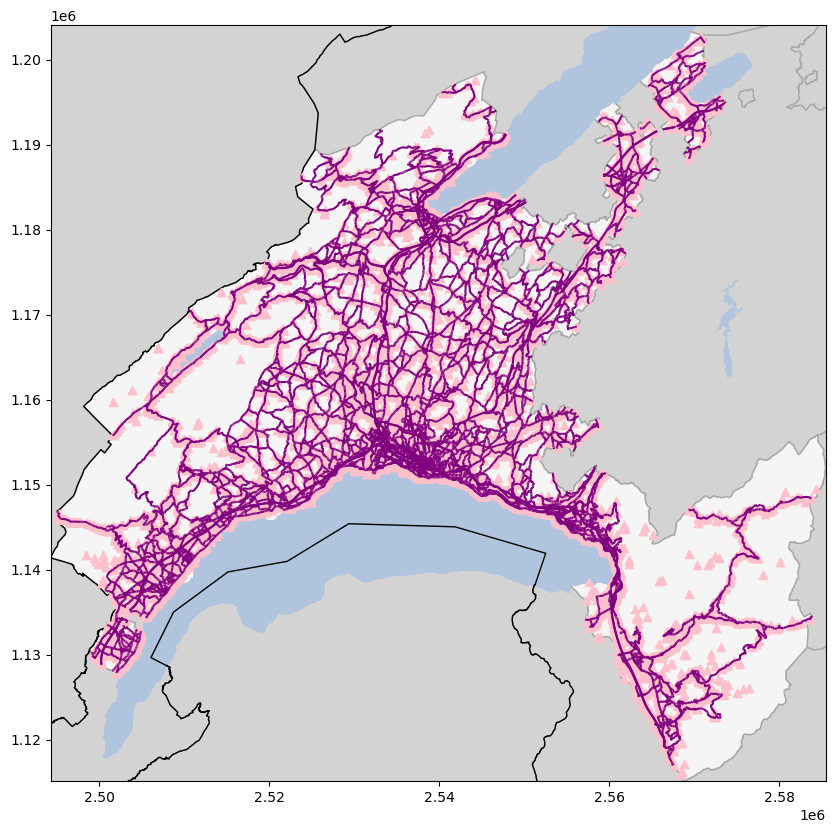

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_facecolor('lightgray')
cantons.plot(ax=ax, facecolor='lightgray', edgecolor = 'darkgray')
study_area.plot(ax=ax, facecolor="whitesmoke", edgecolor="darkgray")
lakes.plot(ax=ax, color ='lightsteelblue')
switzerland.plot(ax=ax,facecolor='none' ,edgecolor='black')
roads_sa.plot(ax=ax, color ='purple')
accidents_sa.plot(ax=ax, color='pink', marker='^')
bounds = study_area.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

## Preprocessing

### Group Roads

In [15]:
columns_to_exclude = ['Nr', 'geometry']
columns_to_include = [col for col in roads_sa.columns if col not in columns_to_exclude]
roads_sa['group_key'] = roads_sa[columns_to_include].astype(str).agg('_'.join, axis=1)
grouped_roads= roads_sa.dissolve(by='group_key')
grouped_roads.reset_index().drop(columns = (['group_key', 'Nr']))
# grouped_roads.to_file("data/output.gpkg", layer="roads_layer", driver="GPKG")
# grouped_roads.to_csv(r'output.csv')

,geometry,DWV_FZG,DWV_PW,DWV_LI,DWV_LW,DWV_LZ,DTV_FZG,DTV_PW,DTV_LI,DTV_LW,...,MSP_FZG,MSP_PW,MSP_LI,MSP_LW,MSP_LZ,ASP_FZG,ASP_PW,ASP_LI,ASP_LW,ASP_LZ
0,MULTILINESTRING Z ((2534483.539 1183799.091 76...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MULTILINESTRING Z ((2537955.628 1152377.972 66...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MULTILINESTRING Z ((2544187.798 1151160.882 66...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MULTILINESTRING Z ((2537483.281 1151429.773 66...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,MULTILINESTRING Z ((2537503.273 1151213.203 66...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10301,MULTILINESTRING Z ((2555634.883 1144819.853 12...,998.0,590.0,394.0,13.0,1.0,898.0,542.0,345.0,10.0,...,57.0,32.0,24.0,1.0,0.0,120.0,67.0,52.0,1.0,0.0
10302,LINESTRING Z (2520397.796 1148344.087 1258.859...,9983.0,8074.0,1613.0,227.0,69.0,9013.0,7360.0,1427.0,175.0,...,876.0,667.0,189.0,15.0,5.0,958.0,681.0,251.0,19.0,6.0
10303,"LINESTRING Z (2533710.686 1156013.865 667.767,...",9983.0,9097.0,610.0,183.0,93.0,9112.0,8362.0,540.0,141.0,...,582.0,524.0,38.0,13.0,7.0,896.0,813.0,61.0,14.0,8.0
10304,"LINESTRING Z (2535959.717 1152040.694 667.767,...",9985.0,9441.0,482.0,50.0,12.0,8870.0,8398.0,425.0,38.0,...,660.0,618.0,37.0,4.0,1.0,1021.0,854.0,153.0,12.0,2.0


### Group accidents by type

In [16]:
# Conversion to bool
accidents_sa['AccidentInvolvingPedestrian'] = accidents_sa['AccidentInvolvingPedestrian'].str.lower() == 'true'
accidents_sa['AccidentInvolvingBicycle'] = accidents_sa['AccidentInvolvingBicycle'].str.lower() == 'true'
accidents_sa['AccidentInvolvingMotorcycle'] = accidents_sa['AccidentInvolvingMotorcycle'].str.lower() == 'true'

In [17]:
# With pedestrian
pedestrian_accidents = accidents_sa[accidents_sa['AccidentInvolvingPedestrian'] == True]
pedestrian_accidents.drop(columns=['AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle'])

# With bicycle
bicycle_accidents = accidents_sa[accidents_sa['AccidentInvolvingBicycle'] == True]
bicycle_accidents.drop(columns=['AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle'])

# With motorcycle
motorcycle_accidents = accidents_sa[accidents_sa['AccidentInvolvingMotorcycle'] == True]
motorcycle_accidents.drop(columns=['AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle'])

# Car only
car_accidents = accidents_sa[
    (accidents_sa['AccidentInvolvingPedestrian'] == False) &
    (accidents_sa['AccidentInvolvingBicycle'] == False) &
    (accidents_sa['AccidentInvolvingMotorcycle'] == False)
]
car_accidents.drop(columns=['AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle'])

,geometry
0,POINT Z (2506801.000 1138068.000 492.363)
2,POINT Z (2534745.000 1157012.000 667.767)
3,POINT Z (2537910.000 1182347.000 760.036)
4,POINT Z (2558042.000 1145032.000 1201.479)
5,POINT Z (2539623.000 1153226.000 667.767)
...,...
21734,POINT Z (2556999.000 1175505.000 501.735)
21736,POINT Z (2542023.000 1151617.000 667.767)
21739,POINT Z (2547362.000 1160818.000 667.767)
21742,POINT Z (2541076.000 1150777.000 667.767)


### Associate accidents to roads

In [18]:
def associate_accidents_to_roads(accidents, roads, new_col_name , max_distance):
    nearest = gpd.sjoin_nearest(accidents, roads, how='inner', distance_col='distance')
    nearest_filtered = nearest[nearest['distance'] <= max_distance]

    accident_counts = nearest_filtered.groupby('index_right').size()

    roads[new_col_name] = roads.index.map(accident_counts).fillna(0).astype(int)
    return roads

roads_accidents = associate_accidents_to_roads(pedestrian_accidents, grouped_roads, 'Pedestrian Accident', 10)
roads_accidents = associate_accidents_to_roads(bicycle_accidents, roads_accidents, 'Bicycle Accident', 10)
roads_accidents = associate_accidents_to_roads(motorcycle_accidents, roads_accidents, 'Motorcycle Accident', 10)
roads_accidents = associate_accidents_to_roads(car_accidents, roads_accidents, 'Car Accident', 10)
    

In [19]:
roads_accidents["DWV_FZG"] = roads_accidents["DWV_FZG"].astype(int)
roads_accidents.loc[roads_accidents["DWV_FZG"] == 0, "DWV_FZG"] = 1

features = roads_accidents[['DWV_PW', 'DWV_LI', 'DWV_LW', 'DWV_LZ', 'MSP_FZG', 'ASP_FZG', 'Pedestrian Accident', 'Bicycle Accident', 'Motorcycle Accident', 'Car Accident']]
features = features.rename(columns={'DWV_PW': 'Cars', 'DWV_LI': 'Delivery Vans', 'DWV_LW': 'Trucks', 'DWV_LZ': 'Articulated lorries', 'MSP_FZG': 'Morning peak', 'ASP_FZG': 'Evening peak'})

features = features.div(roads_accidents['DWV_FZG'], axis=0)
features.reset_index().drop(columns = ('group_key'))

,Cars,Delivery Vans,Trucks,Articulated lorries,Morning peak,Evening peak,Pedestrian Accident,Bicycle Accident,Motorcycle Accident,Car Accident
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,1.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
10301,0.591182,0.394790,0.013026,0.001002,0.057114,0.120240,0.0,0.001002,0.000000,0.000000
10302,0.808775,0.161575,0.022739,0.006912,0.087749,0.095963,0.0,0.000000,0.000000,0.000000
10303,0.911249,0.061104,0.018331,0.009316,0.058299,0.089753,0.0,0.000000,0.000301,0.000000
10304,0.945518,0.048272,0.005008,0.001202,0.066099,0.102253,0.0,0.000000,0.000501,0.000200


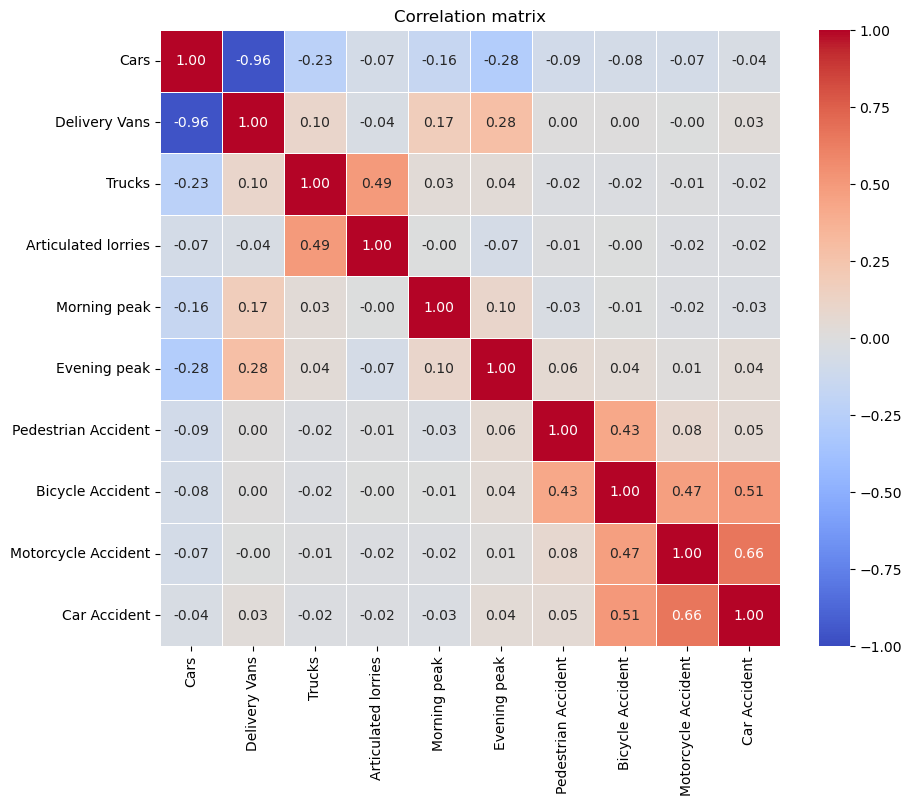

In [20]:
correlation_matrix = features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()

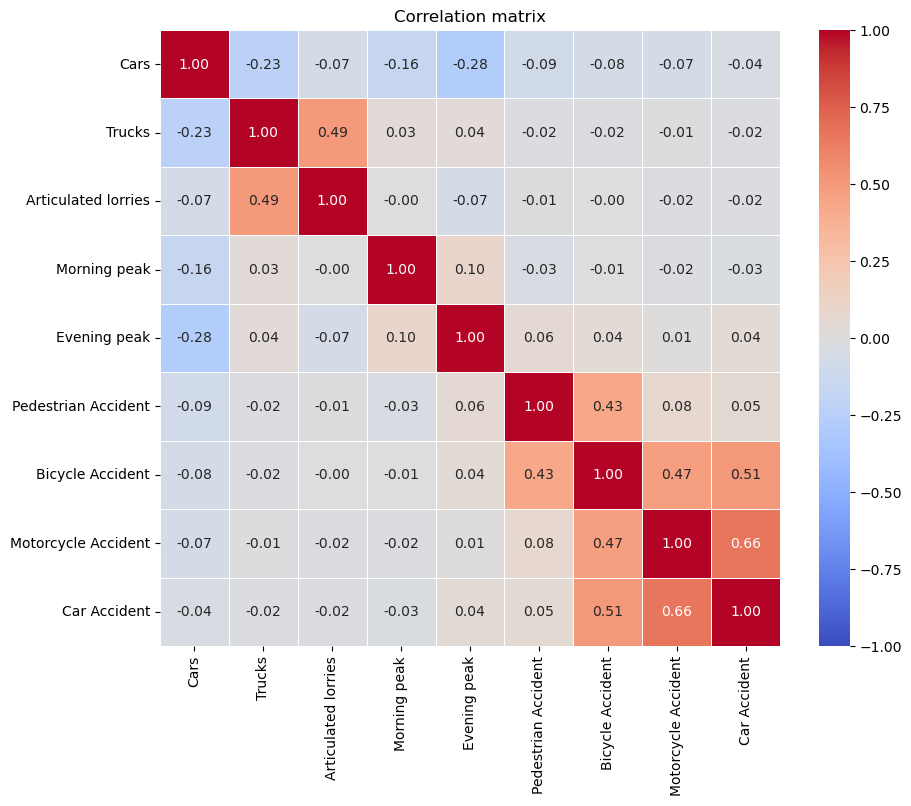

In [21]:
features = features.drop(columns=(['Delivery Vans']))

correlation_matrix = features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()

In [22]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering

In [23]:
k_range = range(2, 21)

silhouette_scores_kmeans = []
silhouette_scores_hac = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(features_scaled)
    silhouette_scores_kmeans.append(silhouette_score(features_scaled, kmeans.labels_))

    hac = AgglomerativeClustering(n_clusters=k)
    hac.fit(features_scaled)
    silhouette_scores_hac.append(silhouette_score(features_scaled, hac.labels_))


Text(0, 0.5, 'Silhouette scores')

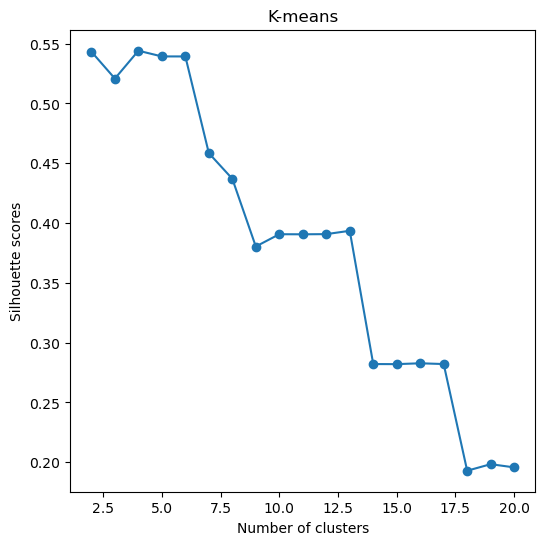

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(k_range, silhouette_scores_kmeans, marker="o")
ax.set_title("K-means")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette scores")

Text(0, 0.5, 'Silhouette scores')

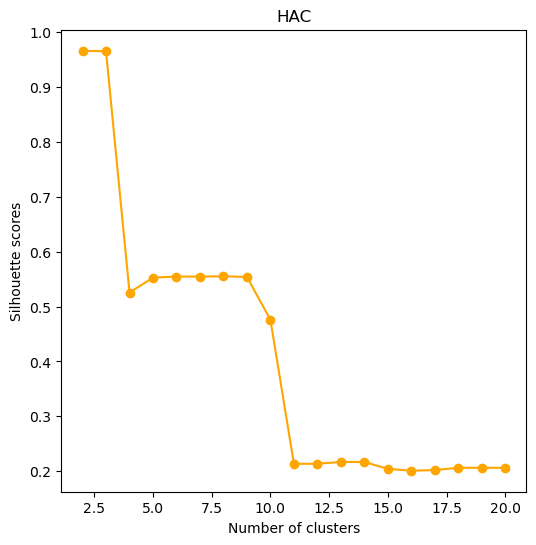

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(k_range, silhouette_scores_hac, marker="o", color="orange")
ax.set_title("HAC")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette scores")

In [26]:
kmeans = KMeans(n_clusters=4, random_state=RANDOM_SEED)

In [27]:
clusters_kmeans = kmeans.fit_predict(features_scaled)

In [28]:
grouped_roads["cluster_kmeans"] = clusters_kmeans

# Visualisation

(1115148.823, 1204075.563)

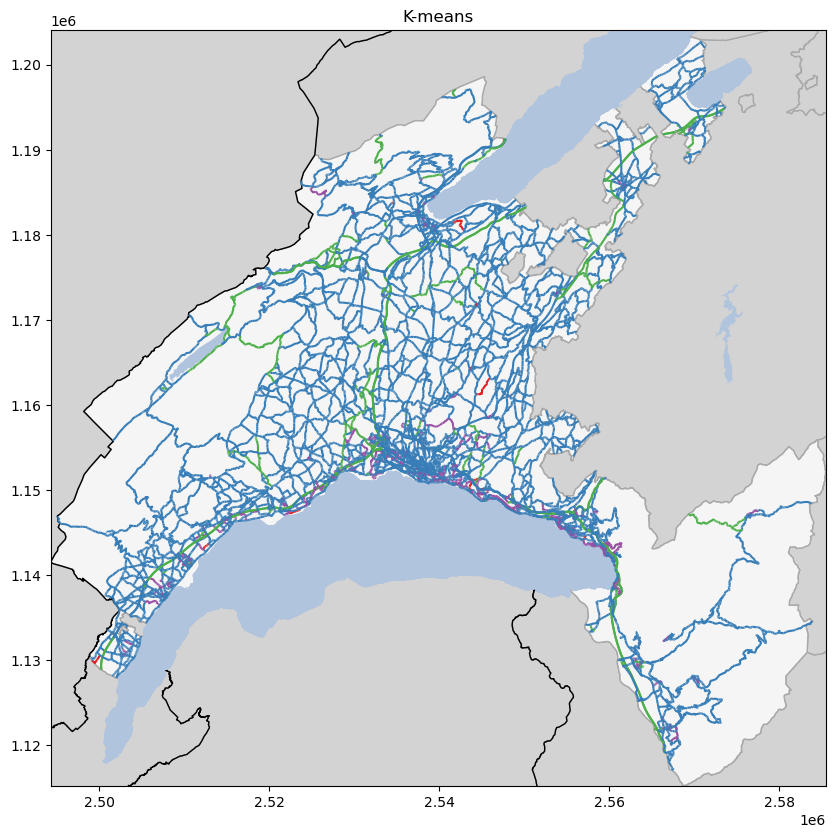

In [29]:
custom_palette = ['#4daf4a', '#377eb8', '#e41a1c', '#984ea3']
custom_cmap = ListedColormap(custom_palette)

fig, ax = plt.subplots(figsize = (10,10))
plt.title("K-means")
ax.set_facecolor('lightgray')
cantons.plot(ax=ax, facecolor='lightgray', edgecolor = 'darkgray')
study_area.plot(ax=ax, facecolor="whitesmoke", edgecolor="darkgray")
switzerland.plot(ax=ax,facecolor='none' ,edgecolor='black')
lakes.plot(ax=ax, color ='lightsteelblue')
grouped_roads.plot(ax=ax, column="cluster_kmeans", cmap=custom_cmap)
bounds = study_area.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

In [30]:
hac = AgglomerativeClustering(n_clusters=2)
clusters_hac = hac.fit_predict(features_scaled)
grouped_roads["cluster_hac"] = clusters_hac

(1115148.823, 1204075.563)

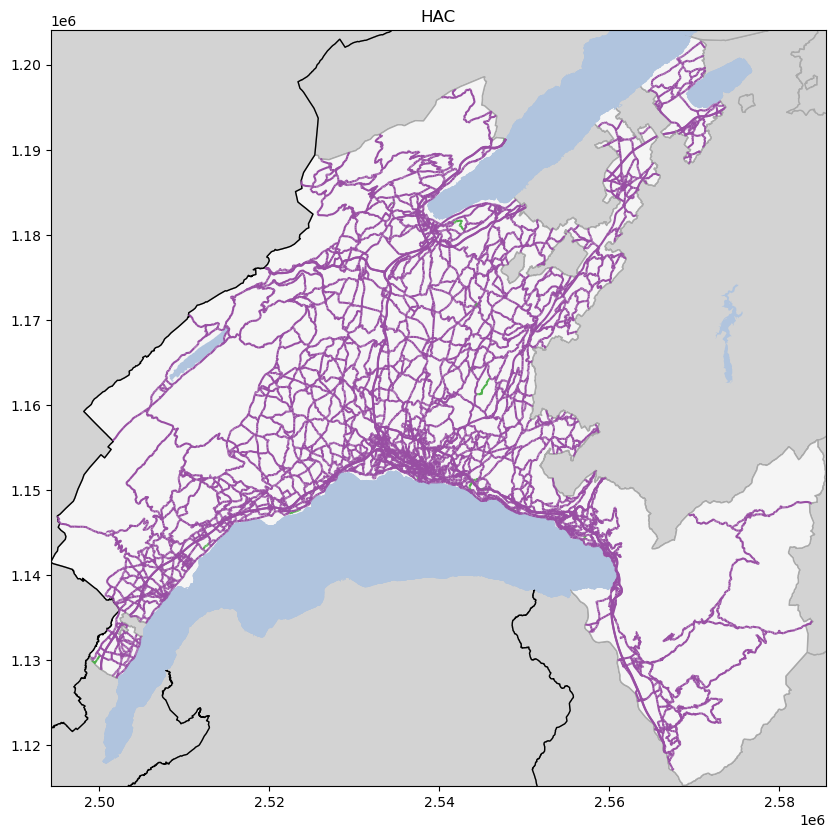

In [31]:
custom_palette = ['#4daf4a', '#377eb8', '#e41a1c', '#984ea3']
custom_cmap = ListedColormap(custom_palette)

fig, ax = plt.subplots(figsize = (10,10))
plt.title("HAC")
ax.set_facecolor('lightgray')
cantons.plot(ax=ax, facecolor='lightgray', edgecolor = 'darkgray')
study_area.plot(ax=ax, facecolor="whitesmoke", edgecolor="darkgray")
switzerland.plot(ax=ax,facecolor='none' ,edgecolor='black')
lakes.plot(ax=ax, color ='lightsteelblue')
grouped_roads.plot(ax=ax, column="cluster_hac", cmap=custom_cmap)
bounds = study_area.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])